In [1]:
!pip install pykalman
!pip install pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48443 sha256=adab8b00ed1ee490c0009d7928e4c609fae40fcbb96bdd514a25d1bf421a6f52
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 3.0 MB/s eta 0:00:00


In [3]:
#
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pykalman import KalmanFilter


data = pd.read_csv('/content/NG2.csv')
data = data.dropna(axis=1, how='all')
data = data.dropna(axis=0, how='all')
# Reverse the DataFrame:
# data = data.iloc[::-1]
# Reset the index:
data = data.reset_index(drop=True)
transport_data = pd.read_csv('/content/transport_ave.csv') #Transport prices Europe-Asia


# Convert 'Date' columns of both dataframes to datetime format
# transport_data['Date'] = pd.to_datetime(transport_data['Date'], format='%d/%m/%Y')
# data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Merge the dataframes on the 'Date' column using a left join
combined_data = data.merge(transport_data, on='Date', how='outer')

# Interpolate missing values for 'Asia' column
combined_data['Transport'] = combined_data['Transport'].interpolate()


#start the model here:
# combined_data = combined_data.drop(combined_data.head(252*5).index)
# combined_data = combined_data.drop(combined_data.tail(252*3).index) #Data without crisis period
combined_data

,Date,JKM,TTF,Transport
0,01/07/2010,6.75,6.05,NaN
1,02/07/2010,6.75,6.05,NaN
2,05/07/2010,6.75,6.16,NaN
3,06/07/2010,6.75,6.22,NaN
4,07/07/2010,6.75,6.08,NaN
...,...,...,...,...
3427,21/08/2023,14.00,11.72,3.07
3428,22/08/2023,14.00,12.60,3.07
3429,23/08/2023,14.00,10.70,3.07
3430,24/08/2023,14.00,9.44,3.07


Estimated Parameters for Europe:
Mean Reversion Strength (theta): 3.73116752451634e-05
Long-Term Mean (mu): 1.926984433580901
Volatility (sigma): 0.6685631142692706

Estimated Parameters for Asia:
Mean Reversion Strength (theta): 9.62838741424462e-06
Long-Term Mean (mu): 2.3377001576247975
Volatility (sigma): 0.6376219989431082

Estimated Parameters for transportation costs:
Mean Reversion Strength (theta): -0.010901815233304975
Long-Term Mean (mu): 0.47667175391317246
Volatility (sigma): 0.4666324932405372
Value of the Destination Flexibility Option: 6.704515592866417
Value of the Destination Flexibility Option %: 51.57319686820321
Correlation between simulated European and Asian prices: 0.8832205458856602
Correlation between simulated transport cost and Asian prices: 0.6914835467054467


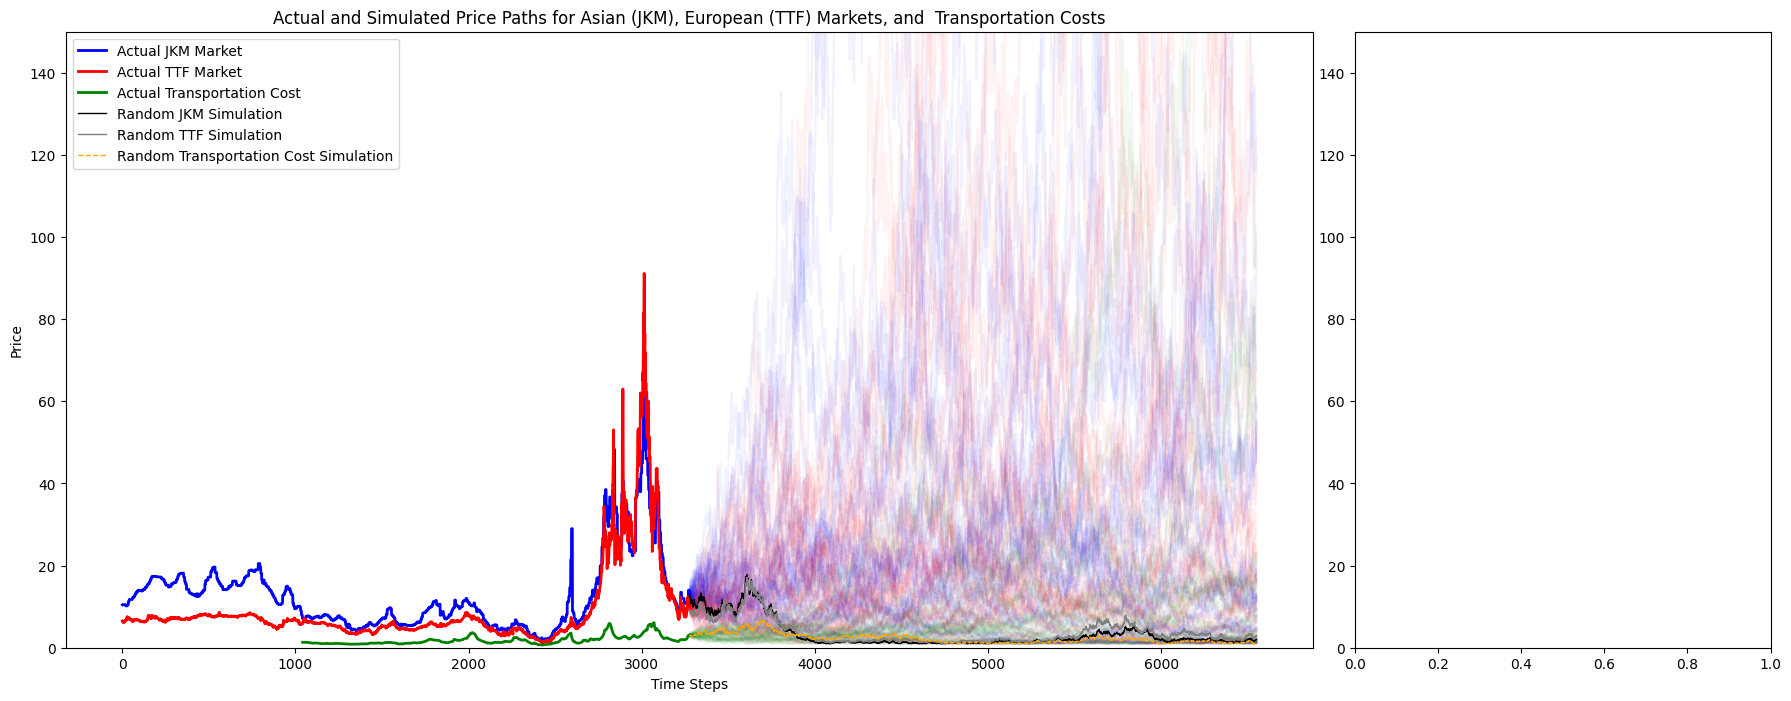

In [6]:
#MWH DATA

dt = 1/252
num_simulations = 10000
discount_rate = 0.05
length = 252*13
correlation_matrix = combined_data['JKM'].tail(length).corr(combined_data['TTF'].tail(length))
corr_jp_asia = combined_data['JKM'].tail(length).corr(combined_data['Transport'].tail(length))
corr_de_asia = combined_data['TTF'].tail(length).corr(combined_data['Transport'].tail(length))



def ornstein_uhlenbeck_process_three(params_JP, params_DE, params_ASIA, S0_JP, S0_DE, S0_ASIA, dt, num_steps, num_simulations, correlation_matrix):
    theta_JP, mu_JP, sigma_JP = params_JP
    theta_DE, mu_DE, sigma_DE = params_DE
    theta_ASIA, mu_ASIA, sigma_ASIA = params_ASIA

    # Prices matrices
    S_t_JP = np.zeros((num_simulations, num_steps))
    S_t_JP[:, 0] = S0_JP
    S_t_DE = np.zeros((num_simulations, num_steps))
    S_t_DE[:, 0] = S0_DE
    S_t_ASIA = np.zeros((num_simulations, num_steps))
    S_t_ASIA[:, 0] = S0_ASIA

    uncorrelated_random_variables = np.random.normal(size=(num_simulations, num_steps, 3))
    cov = np.array([[1, correlation_matrix, corr_jp_asia],
                [correlation_matrix, 1, corr_de_asia],
                [corr_jp_asia, corr_de_asia, 1]])

    L = np.linalg.cholesky(cov)
    correlated_random_variables = np.matmul(uncorrelated_random_variables, L.T)

    for i in range(1, num_steps):
        # For JP
        dW_JP = correlated_random_variables[:, i, 0] * np.sqrt(dt)
        S_t_JP[:, i] = S_t_JP[:, i - 1] + theta_JP * (mu_JP - S_t_JP[:, i - 1]) * dt + sigma_JP * dW_JP
        S_t_JP[:, i] = np.maximum(S_t_JP[:, i], 0)

        # For DE
        dW_DE = correlated_random_variables[:, i, 1] * np.sqrt(dt)
        S_t_DE[:, i] = S_t_DE[:, i - 1] + theta_DE * (mu_DE - S_t_DE[:, i - 1]) * dt + sigma_DE * dW_DE
        S_t_DE[:, i] = np.maximum(S_t_DE[:, i],0)

        # For ASIA
        dW_ASIA = correlated_random_variables[:, i, 2] * np.sqrt(dt)
        S_t_ASIA[:, i] = S_t_ASIA[:, i - 1] + theta_ASIA * (mu_ASIA - S_t_ASIA[:, i - 1]) * dt + sigma_ASIA * dW_ASIA
        S_t_ASIA[:, i] = np.maximum(S_t_ASIA[:, i], 0)

    return S_t_JP, S_t_DE, S_t_ASIA

# Function to estimate parameters using Kalman Filter
def estimate_parameters(prices, dt):
    # Remove any invalid or missing data points
    prices = prices.dropna()

    # Define the Kalman Filter
    kf = KalmanFilter(transition_matrices=[1],
                      observation_matrices=[1],
                      initial_state_mean=np.mean(prices),
                      initial_state_covariance=np.std(prices),
                      observation_covariance=1,
                      transition_covariance=0.01)

    # Use the observations to estimate the model parameters
    state_means, _ = kf.filter(prices.values)

    theta = 1 - state_means[:-1] / state_means[1:]
    mu = state_means[1:] / (1 - theta)
    sigma = np.sqrt(np.var(state_means[1:] - theta * state_means[:-1]))

    # Return the mean of each parameter
    return np.mean(theta), np.mean(mu), np.mean(sigma)

# Function to calculate the payoff of the destination flexibility option
def calculate_option_payoff(prices_JP, prices_DE, transportation_cost_simulated):
    return np.maximum(prices_DE - prices_JP - transportation_cost_simulated, 0)

def calculate_option_value(params_JP, params_DE, params_ASIA, S0_JP, S0_DE, S0_ASIA, dt, num_steps, num_simulations, discount_rate, correlation_matrix):
    prices_JP, prices_DE, transportation_costs = ornstein_uhlenbeck_process_three(params_JP, params_DE, params_ASIA, S0_JP, S0_DE, S0_ASIA, dt, num_steps, num_simulations, correlation_matrix)
    option_values = []
    option_values_per_step = np.zeros((num_simulations, num_steps))
    for i in range(num_simulations):
        payoff = calculate_option_payoff(np.exp(prices_JP[i]), np.exp(prices_DE[i]), np.exp(transportation_costs[i]))
        option_value = np.mean(payoff) * np.exp(-discount_rate * dt * num_steps)
        option_values.append(option_value)
        option_values_per_step[i] = payoff * np.exp(-discount_rate * dt * num_steps)
    mean_option_value = np.mean(option_values)
    return mean_option_value, prices_JP, prices_DE, transportation_costs, option_values_per_step

jp_prices = np.log(combined_data['JKM'].tail(length))
de_prices = np.log(combined_data['TTF'].tail(length))
asia_prices = np.log(combined_data['Transport'].tail(length))

theta_de, mu_de, sigma_de = estimate_parameters(de_prices, dt)
theta_jp, mu_jp, sigma_jp = estimate_parameters(jp_prices, dt)
theta_asia, mu_asia, sigma_asia = estimate_parameters(asia_prices, dt)


print("Estimated Parameters for Europe:")
print("Mean Reversion Strength (theta):", theta_de)
print("Long-Term Mean (mu):", mu_de)
print("Volatility (sigma):", sigma_de)

print("\nEstimated Parameters for Asia:")
print("Mean Reversion Strength (theta):", theta_jp)
print("Long-Term Mean (mu):", mu_jp)
print("Volatility (sigma):", sigma_jp)

print("\nEstimated Parameters for transportation costs:")
print("Mean Reversion Strength (theta):", theta_asia)
print("Long-Term Mean (mu):", mu_asia)
print("Volatility (sigma):", sigma_asia)


option_value, prices_JP, prices_DE, simulated_transportation_costs, option_values_per_step = calculate_option_value(
    [theta_jp, mu_jp, sigma_jp],
    [theta_de, mu_de, sigma_de],
    [theta_asia, mu_asia, sigma_asia],
    jp_prices.iloc[-1], de_prices.iloc[-1], asia_prices.iloc[-1],
    dt, length, num_simulations, discount_rate, correlation_matrix
)



print("Value of the Destination Flexibility Option:", option_value)
print("Value of the Destination Flexibility Option %:", (option_value/np.exp(jp_prices.iloc[-1]))*100)


correlation_JP = np.corrcoef(prices_JP.flatten(), prices_DE.flatten())[0, 1]
correlation_trans = np.corrcoef(simulated_transportation_costs.flatten(), prices_DE.flatten())[0, 1]
print("Correlation between simulated European and Asian prices:", correlation_JP)
print("Correlation between simulated transport cost and Asian prices:", correlation_trans)

prices_JP_flat = pd.Series(prices_JP.flatten())
prices_DE_flat = pd.Series(prices_DE.flatten())



# ###################PLOTTING#######################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

jp_actual_prices = combined_data['JKM'].tail(length).values
de_actual_prices = combined_data['TTF'].tail(length).values
asia_actual_prices = combined_data['Transport'].tail(length).values  # Actual transportation prices

# Create a grid for the plots
fig = plt.figure(figsize=(22, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

ax0 = plt.subplot(gs[0])

# Length of actual prices
len_actual_prices = len(jp_actual_prices)

# Plot actual prices first
ax0.plot(range(len_actual_prices), jp_actual_prices, color='blue', label='Actual JKM Market', linewidth=2)
ax0.plot(range(len_actual_prices), de_actual_prices, color='red', label='Actual TTF Market', linewidth=2)
ax0.plot(range(len_actual_prices), asia_actual_prices, color='green', label='Actual Transportation Cost', linewidth=2)

# Plot simulated prices and transportation costs
for i in range(50):
    ax0.plot(range(len_actual_prices, len_actual_prices + len(prices_JP[i])), np.exp(prices_JP[i]), color='blue', alpha=0.05)
    ax0.plot(range(len_actual_prices, len_actual_prices + len(prices_DE[i])), np.exp(prices_DE[i]), color='red', alpha=0.05)
    ax0.plot(range(len_actual_prices, len_actual_prices + len(simulated_transportation_costs[i])), np.exp(simulated_transportation_costs[i]), color='green', alpha=0.05)

# Plot the specific simulation with a thicker line
random_index = np.random.randint(0, 100)
ax0.plot(range(len_actual_prices, len_actual_prices + len(prices_JP[random_index])), np.exp(prices_JP[random_index]), color='black', linewidth=1, label='Random JKM Simulation')
ax0.plot(range(len_actual_prices, len_actual_prices + len(prices_DE[random_index])), np.exp(prices_DE[random_index]), color='grey', linewidth=1, label='Random TTF Simulation')
ax0.plot(range(len_actual_prices, len_actual_prices + len(simulated_transportation_costs[random_index])), np.exp(simulated_transportation_costs[random_index]), color='orange', linewidth=1, linestyle='--', label='Random Transportation Cost Simulation')

ax0.set_title('Actual and Simulated Price Paths for Asian (JKM), European (TTF) Markets, and  Transportation Costs')
ax0.set_xlabel('Time Steps')
ax0.set_ylabel('Price')
ax0.legend()


# Create a new subplot for the distribution plot
ax1 = plt.subplot(gs[1])


# # Create the combined distribution plot on the right
# ax1 = plt.subplot(gs[1], sharey=ax0)
# ax1.hist(np.exp(prices_JP.flatten()), color='blue', orientation='horizontal', alpha=0.5, label='JKM Market', bins=550)
# ax1.hist(np.exp(prices_DE.flatten()), color='red', orientation='horizontal', alpha=0.5, label='TTF Market', bins=550)
# ax1.hist(np.exp(simulated_transportation_costs.flatten()), color='green', orientation='horizontal', alpha=0.5, label='Transportation Cost', bins=550)
# ax1.set_xlabel('Frequency')
# ax1.legend()

ax0.set_ylim(bottom=0, top=150)
ax1.set_ylim(bottom=0, top=150)


# Adjust the space between the plots
plt.subplots_adjust(wspace=0.05)
plt.show()